# 基本配置

In [1]:
!pip install -r requirements.txt

## 导入库

In [2]:
import os
import platform
import zipfile
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
import tensorflow as tf

/Users/weichen/Desktop/GraduationProject/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 设置绘图的中文字体

In [3]:
# # 设置 matplotlib 支持中文显示
# plt.rcParams['font.sans-serif'] = ['SimHei'] if platform.system() == 'Windows' else ['Heiti TC']
# plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# # 测试代码，显示当前字体设置
# print(f"当前字体设置: {plt.rcParams['font.family']}")

## 使用GPU加速

In [4]:
# 检查操作系统
if platform.system() == 'Windows':
    # Windows平台
    # 设置TensorFlow使用Nvidia GPU
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # 设置GPU内存增长，避免占用全部GPU内存
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("正在使用 GPU 运行")
        except RuntimeError as e:
            # 打印异常
            print("发生错误：", e)
elif platform.system() == 'Darwin':
    # MacOS平台
    # 检查是否支持Apple M1芯片GPU
    try:
        # 尝试设置TensorFlow以使用Apple M1芯片的GPU
        if tf.config.list_physical_devices('GPU'):
            print("正在使用 Apple M1 GPU 运行")
        else:
            # 如果没有可用的GPU，将使用CPU
            print("正在使用 CPU 运行")
    except Exception as e:
        print("发生错误：", e)
else:
    # 其他平台，默认使用CPU
    print("正在使用 CPU 运行")

正在使用 Apple M1 GPU 运行


# 解压数据
- Original_dataset 文件夹

In [5]:
# 检查解压目录是否已存在
if not os.path.exists('./BreaKHis_v1'):
    # 解压 zip 文件
    with zipfile.ZipFile('./dataset.zip') as zip_ref:
        zip_ref.extractall('./')
        print('数据集已解压文件夹')
else:
    print('数据集文件已存在，无需解压。')

数据集文件已存在，无需解压。


- BreaKHis_v1
    - BreaKHis_v1
        - histology_slides
            - breast
                - **benign**
                    - **SOB**
                        - 类型
                            - **患者ID**
                                - 40x
                                - 100x
                                - 200x
                                - 400x
                - **malignant**
                    - **SOB**
                        - 类型
                            - **患者ID**
                                - 40x
                                - 100x
                                - 200x
                                - 400x

# 文件读取

In [6]:
def process_dataset(root_dir):
    data = {"image_path": [], "label": [], "zoom_level": []}

    # 遍历'benign'和'malignant'文件夹
    for label in ['benign', 'malignant']:
        label_dir = os.path.join(root_dir, label, "SOB")

        # 遍历每个类型的目录
        for type_dir in os.listdir(label_dir):
            type_dir_path = os.path.join(label_dir, type_dir)

            # 遍历每个患者ID的目录
            for patient_id_dir in os.listdir(type_dir_path):
                patient_dir_path = os.path.join(type_dir_path, patient_id_dir)

                # 遍历每个zoom level的目录
                for zoom_level_dir in os.listdir(patient_dir_path):
                    zoom_dir_path = os.path.join(patient_dir_path, zoom_level_dir)

                    # 遍历zoom级别的目录
                    for img_file in os.listdir(zoom_dir_path):
                        img_file_path = os.path.join(zoom_dir_path, img_file)

                        # 将图像路径，对应的zoom level和标签加入到data字典中
                        data["image_path"].append(img_file_path)
                        data["label"].append(label)
                        data["zoom_level"].append(zoom_level_dir)

    # 创建一个基于data的pandas DataFrame
    df = pd.DataFrame(data)
    return df

In [7]:
root_dir = "./BreaKHis_v1/BreaKHis_v1/histology_slides/breast"
df = process_dataset(root_dir)
df

,image_path,label,zoom_level
0,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X
1,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X
2,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X
3,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X
4,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X
...,...,...,...
7904,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,200X
7905,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,200X
7906,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,200X
7907,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,200X


## 数据集可视化

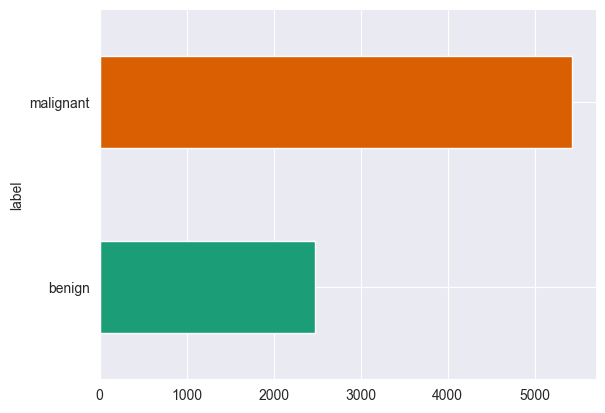

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

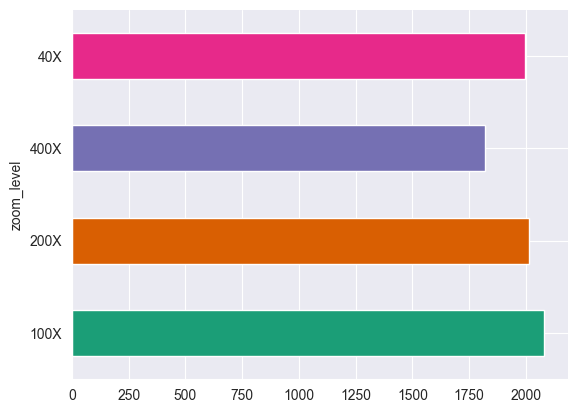

In [9]:
df.groupby('zoom_level').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## 数据集过滤

In [10]:
df_filtered = df[df['zoom_level'] == '40X']
df = df_filtered
df

,image_path,label,zoom_level
60,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,40X
61,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,40X
62,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,40X
63,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,40X
64,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,40X
...,...,...,...
7876,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,40X
7877,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,40X
7878,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,40X
7879,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,40X


# 数据集划分
- X_train, X_val, X_test分别包含了训练集、验证集和测试集的图片数据
- y_train, y_val, y_test分别包含了对应的类别标签

**标签转化为整数**

In [11]:
from sklearn.preprocessing import LabelEncoder

# 创建一个 LabelEncoder 对象
label_encoder = LabelEncoder()

# 使用 fit_transform 方法将类别标签转换为整数
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# 查看编码后的标签对应的原始标签
print(label_encoder.classes_)
df

['benign' 'malignant']


/var/folders/_r/dxlgh_x962x9n83c_pfm2zph0000gn/T/ipykernel_1320/183798384.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_encoded'] = label_encoder.fit_transform(df['label'])


,image_path,label,zoom_level,label_encoded
60,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,40X,0
61,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,40X,0
62,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,40X,0
63,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,40X,0
64,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,40X,0
...,...,...,...,...
7876,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,40X,1
7877,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,40X,1
7878,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,40X,1
7879,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,40X,1


**划分数据集**

In [12]:
from sklearn.model_selection import train_test_split

# 先将原数据集划分为80%的训练集和20%的（验证集+测试集）
train_df, val_test_df = train_test_split(df, test_size=0.2, stratify=df['label_encoded'])

# 再将（验证集+测试集）均匀划分为验证集和测试集
val_df, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['label_encoded'])

In [13]:
train_df.shape, val_df.shape, test_df.shape

((1596, 4), (199, 4), (200, 4))

# 超参数

## **采用滑动平均设置早停**

In [14]:
class EarlyStoppingWithSMA(tf.keras.callbacks.Callback):
    def __init__(self, patience=0, verbose=0):
        super(EarlyStoppingWithSMA, self).__init__()
        self.patience = patience
        self.verbose = verbose
        # 滑动平均的权重
        self.alpha = 0.1
        # 初始化最佳损失为无穷大
        self.best_loss = np.inf
        # 初始化等待计数器
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')
        # 计算损失的滑动平均值
        self.best_loss = self.alpha * current_loss + (1 - self.alpha) * self.best_loss
        if np.less(current_loss, self.best_loss):
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
                if self.verbose > 0:
                    print('Epoch {}: early stopping'.format(epoch+1))
early_stopping = EarlyStoppingWithSMA(patience=10, verbose=1)

**TensorBoard回调**
- tensorboard --logdir ./logs
- %load_ext tensorboard
- %tensorboard --logdir ./logs

In [15]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')

## **打包回调函数**

In [16]:
callbacks = [
    early_stopping,
    tensorboard_callback
]

## **类别权重**
- 首先将使用 compute_class_weight 来为每个类别计算权重。
- 然后，将遍历每个独立的类别，并创建一个字典，其中键是类的标签，值是对应的权重。
- 最后显示生成的 weight_dict 就可以看到每个类别对应的权重。

In [17]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def get_class_weights(label):
    """
    输入y是一个列表或者numpy数组
    这个函数将为整个数据集中每个独立的类别计算权重
    返回值是一个字典，键是类的标签，值是对应的权重
    """
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(label), y=label)
    
    weight_dict = {class_label: class_weights[i] for i, class_label in enumerate(np.unique(label))}
    
    return weight_dict

class_weights = get_class_weights(df['label_encoded'])

## 使用余弦退火调整学习率

In [18]:
# 初始学习率
initial_learning_rate = 0.001
# 定义训练步数，这里以一个epoch中样本数据被完全遍历一次作为一步
decay_steps = len(train_df)/16 * 10 # 这个设置将使学习率在大约 10 个 epoch 后衰减到较低的水平

# 定义余弦退火的学习率
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps)

# 创建一个新的 Adam 优化器实例，并使用上述的学习率计划
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

2024-04-30 11:28:22.583196: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-30 11:28:22.583218: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-30 11:28:22.583222: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-30 11:28:22.583241: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-30 11:28:22.583256: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 数据生成器
- 首先使用 cv2 读取和预处理图像（修改尺寸、归一化等）
- 然后通过一个 if 条件判断是否应用增强
- 如果选择应用增强，就用 albumentations 的弹性变形等增强操作处理图像
- 对图像进行了归一化，并把它的类型从 uint8/uint16 转换成了 float64, 然后再把图像传递给 albumentations 进行增强。但是 albumentations 并不支持 float64 类型的数据，可以在使用 albumentations 进行数据增强之前，不进行归一化。等增强完成之后，再将其归一化到 [0, 1] 范围

下面是一些主要的增强操作及其参数的解释：
`A.Compose`：用于组合多个图像增强操作的函数。
`A.HorizontalFlip(p=0.5)`：水平翻转操作。`p=0.5`表示每个图像有50%的概率被翻转。
`A.RandomBrightnessContrast(p=0.2)`：随机调整亮度和对比度的操作。`p=0.2`表示每个图像有20%的概率进行亮度和对比度的调整。
- `A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2)`：随机平移、缩放和旋转的操作。`shift_limit`、`scale_limit`和`rotate_limit`分别表示平移、缩放和旋转的范围。`p=0.2`表示每个图像有20%的概率进行平移、缩放和旋转。
`A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=2, min_height=8, min_width=8, fill_value=0, p=0.5)`：粗略的随机像素丢失操作。`max_holes`、`max_height`和`max_width`表示丢失像素块的最大数量和大小，`min_holes`、`min_height`和`min_width`表示丢失像素块的最小数量和大小。`fill_value`表示丢失的像素块的填充值。`p=0.5`表示每个图像有50%的概率进行像素丢失。
这些操作可以增强图像数据，提高模型的泛化能力。 

In [19]:
# def create_data_generator(df, batch_size, augmentation=False):
#     # 创建 albumentations 变换链
#     transform = A.Compose([
#         A.RandomCrop(width=350, height=230),
#         A.HorizontalFlip(p=0.5),
#         A.RandomBrightnessContrast(p=0.2),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
#         A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=2, min_height=8, min_width=8, fill_value=0, p=0.5),
#         A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03) # 模拟生物组织的非刚性形变
#     ], p=1)
# 
#     while True:
#         batch = df.sample(batch_size)
#         images = []
#         labels = []
# 
#         for i in range(batch.shape[0]):
#             img_path = batch.iloc[i]['image_path']
#             img = cv2.imread(img_path)
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV 读取图像默认使用 BGR，转换为 RGB
#             img = cv2.resize(img, (350, 230))
#             img = img / 255.0  # 将像素值归一化到 [0,1] 之间
# 
#             if augmentation:
#                 # 将 albumentations 变换应用于图像
#                 img = transform(image=img)["image"]
# 
#             images.append(img)
#             labels.append(batch.iloc[i]['label_encoded'])
# 
#         yield np.array(images), np.array(labels)

In [20]:
# # 考虑类别权重的情况修改后的代码
# def create_data_generator(df, class_weights, batch_size, augmentation=False):
#     # 创建 albumentations 变换链
#     transform = A.Compose([
#         A.RandomCrop(width=350, height=230),
#         A.HorizontalFlip(p=0.5),
#         A.RandomBrightnessContrast(p=0.3),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
#         A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=2, min_height=8, min_width=8, fill_value=0, p=0.1)
#         # A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03) # 模拟生物组织的非刚性形变
#     ], p=0.5)
# 
#     while True:
#         # 随机选择一个batch的数据
#         batch = df.sample(batch_size)
#         images = []
#         labels = []
#         sample_weights = []
# 
#         for i in range(batch.shape[0]):
#             # 使用cv2读取图片, 转换尺寸, 归一化
#             img_path = batch.iloc[i]['image_path']
#             img = cv2.imread(img_path)
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV 读取图像默认使用 BGR，转换为 RGB
#             img = cv2.resize(img, (350, 230))
# 
#             if augmentation:
#                 # 将 albumentations 变换应用于图像
#                 img = transform(image=img)["image"]
# 
#             img = img / 255.0   # 将像素值归一化到 [0,1] 之间
#             
#             label = batch.iloc[i]['label_encoded']
#             images.append(img)
#             labels.append(label)
# 
#             # 添加样本权重
#             sample_weights.append(class_weights[label])
# 
#         yield np.array(images), np.array(labels), np.array(sample_weights)

In [21]:
# def create_data_generator(df, class_weights, batch_size, augmentation=False):
#     # 创建 albumentations 变换链
#     transform = A.Compose([
#         A.RandomCrop(width=350, height=230),
#         A.HorizontalFlip(p=0.5),
#         A.RandomBrightnessContrast(p=0.3),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
#         A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=2, min_height=8, min_width=8, fill_value=0, p=0.2),
#     ], p=1)
# 
#     # 打乱数据
#     df = df.sample(frac=1).reset_index(drop=True)
#     
#     # 分割 DF 成各个批次
#     df_batches = np.array_split(df, len(df) // batch_size)
# 
#     while True:
#         for batch in df_batches:
#             images = []
#             labels = []
#             sample_weights = []
# 
#             for i in range(batch.shape[0]):
#                 img_path = batch.iloc[i]['image_path']
#                 img = cv2.imread(img_path)
#                 img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#                 img = cv2.resize(img, (350, 230))
# 
#                 if augmentation:
#                     img = transform(image=img)["image"]
# 
#                 img = img / 255.0 
#                 label = batch.iloc[i]['label_encoded']
#                 images.append(img)
#                 labels.append(label)
#                 sample_weights.append(class_weights[label])
# 
#             yield np.array(images), np.array(labels), np.array(sample_weights)

In [22]:
def create_data_generator(df, class_weights, batch_size, augmentation=False):
    transform = A.Compose([
        A.RandomCrop(width=350, height=230),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=2, min_height=8, min_width=8, fill_value=0, p=0.1)
    ], p=0.5)


    df_batches = np.array_split(df, len(df) // batch_size)

    while True:
        np.random.shuffle(df_batches)

        for batch in df_batches:
            images = []
            labels = []
            sample_weights = []


            for i in range(batch.shape[0]):
                try:
                    # 使用cv2读取图片, 转换尺寸, 归一化
                    img_path = batch.iloc[i]['image_path']
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (350, 230))

                    if augmentation:
                        img = transform(image=img)["image"]

                    img = img / 255.0 

                    label = batch.iloc[i]['label_encoded']
                    images.append(img)
                    labels.append(label)
                    sample_weights.append(class_weights[label])
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
                    continue  # 如果有问题,跳过此图像并继续处理

            yield np.array(images), np.array(labels), np.array(sample_weights)

**测试数据生成器是否能遍历所有图片数据**

/Users/weichen/Desktop/GraduationProject/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


(32, 230, 350, 3)
(32,)
(32,)
0.0
1.0


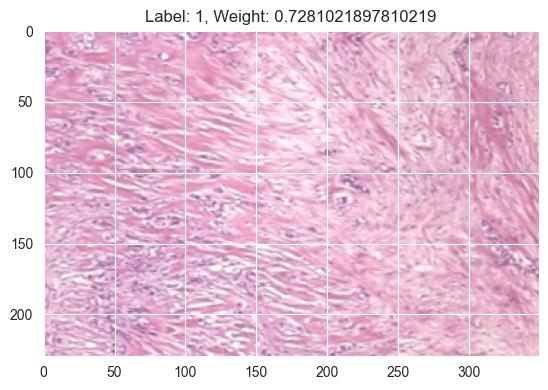

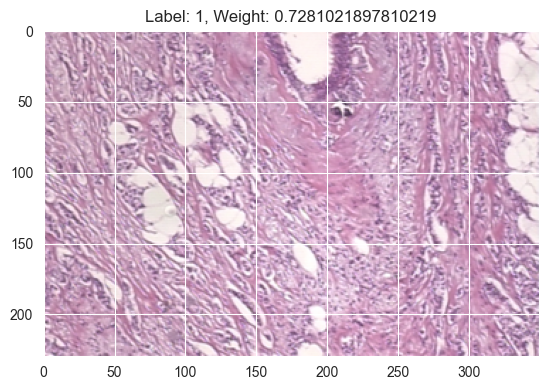

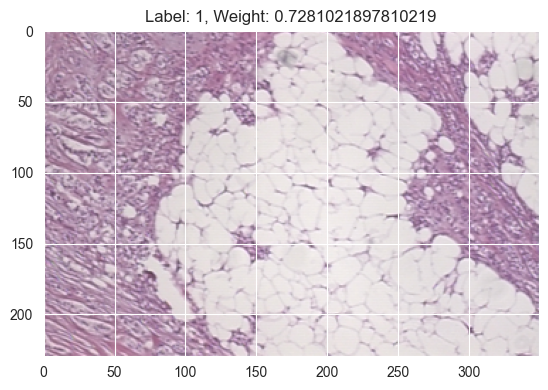

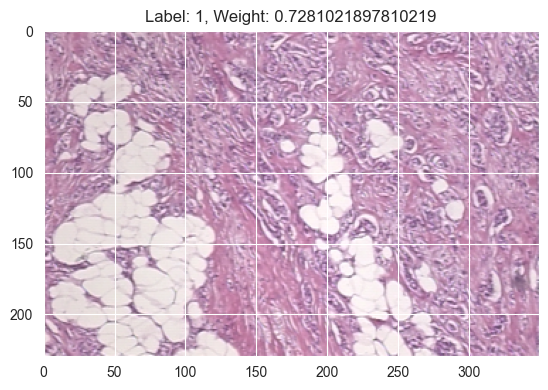

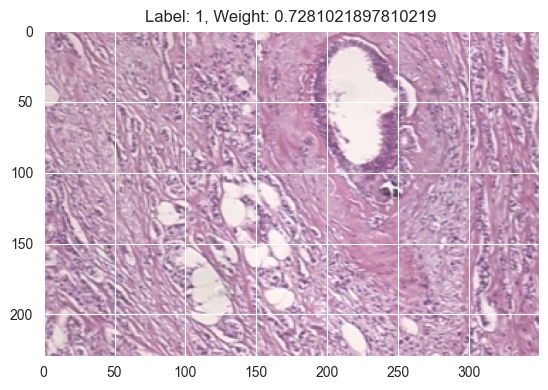

In [23]:
# 首先创建一个数据生成器
gen = create_data_generator(df, class_weights, batch_size=32, augmentation=True)

# 然后从生成器中获取一批数据
images, labels, sample_weights = next(gen)

# 检查返回的数据的形状
print(images.shape)  # 应该是 (batch_size, 230, 350, 3)
print(labels.shape)  # 应该是 (batch_size, )
print(sample_weights.shape)  # 应该是 (batch_size, )

# 检查图像数据是否已经归一化
print(images.min())  # 应该是 0
print(images.max())  # 应该是 1

# 展示一些图片
import matplotlib.pyplot as plt

for i in range(5):  # 展示前五张图片
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}, Weight: {sample_weights[i]}")
    plt.show()

# 模型构建
以下是模型每一层的参数描述：

- 卷积层 1：类型：卷积，过滤器/通道数：32，过滤器大小：5x5，步长：1x1，填充：Same，激活函数：ReLU。
- 池化层 2：类型：最大池化，池大小：3x3，步长：1x1。
- 卷积层 3：类型：卷积，过滤器/通道数：64，过滤器大小：5x5，步长：1x1，填充：None，激活函数：ReLU。
- 池化层 4：类型：最大池化，池大小：3x3，步长：1x1。
- 卷积层 5：类型：卷积，过滤器/通道数：128，过滤器大小：5x5，步长：1x1，填充：None，激活函数：ReLU。
- 池化层 6：类型：最大池化，池大小：3x3，步长：1x1。
- 全连接层 1：类型：全连接，节点数：64，激活函数：ReLU。
- 全连接层 2：类型：全连接，节点数：64，激活函数：ReLU。
- 全连接层 3（输出层）：类型：全连接，节点数：2（每个类别一个节点），激活函数：Softmax。

模型使用 ADAM 优化器，损失函数为分类交叉熵，评价指标为准确度（accuracy）。

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(230, 350, 3)),
    # Layer 1: Convolutional
    tf.keras.layers.Conv2D(32, (5,5), strides=(1, 1), padding='same', activation='relu'), 
    # Layer 2: Pooling
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(1,1)),
    # Layer 3: Convolutional
    tf.keras.layers.Conv2D(64, (5,5), strides=(1, 1), padding='valid', activation='relu'),
    # Layer 4: Pooling 
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(1,1)),
    # Layer 5: Convolutional
    tf.keras.layers.Conv2D(128, (5,5), strides=(1, 1), padding='valid', activation='relu'),
    # Layer 6: Pooling
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(1,1)),
    # Flatten the tensor output of the Convolutional layers
    tf.keras.layers.Flatten(),
    # Layer 7: Fully connected 1 (64 nodes)
    tf.keras.layers.Dense(64, activation='relu'),
    # Layer 8: Fully connected 2 (64 nodes)
    tf.keras.layers.Dense(64, activation='relu'),
    # Layer 9: Fully connected 3 (2 nodes)
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 230, 350, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 228, 348, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 344, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 222, 342, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 218, 338, 128)  │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 216, 336, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9289728)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │   594,542,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 594,805,570 (2.22 GB)

 Trainable params: 594,805,570 (2.22 GB)

 Non-trainable params: 0 (0.00 B)

# 模型编译

In [25]:
# Compile the Model
model.compile(optimizer=optimizer, 
            #   loss='categorical_crossentropy', # 独热编码对应的损失函数
              loss='sparse_categorical_crossentropy', # 整数编码对应的损失函数
              metrics=['accuracy'])

# 模型训练

In [ ]:
batch_size = 8
train_generator = create_data_generator(train_df, class_weights, batch_size=batch_size, augmentation=True)
val_generator = create_data_generator(val_df, class_weights, batch_size=batch_size, augmentation=False)

history = model.fit(
    x=train_generator,
    steps_per_epoch=len(train_df) // batch_size,  # 一个epoch包含的步骤
    validation_data=val_generator,
    validation_steps=len(val_df) // batch_size,  # 一个epoch的验证步骤
    epochs=50,
    verbose=1,
    shuffle=True,
    callbacks=callbacks,
)

Epoch 1/50


2024-04-30 11:28:25.402302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


  2/199 ━━━━━━━━━━━━━━━━━━━━ 57:22 17s/step - accuracy: 0.7812 - loss: 28.2312

# 模型保存

**加载模型进行评估**

# 模型评估
- 计算精度（Precision）
- 召回率（Recall）
- F1-Score
- 混淆矩阵（Confusion Matrix）

In [ ]:
from sklearn.metrics import classification_report

# 假设 test_data 是你的测试数据
predictions = model.predict(y_test)

# 模型的 predict 方法会返回每个类别的概率，因此我们需要选择概率最大的类别作为预测的类别
predicted_classes = np.argmax(predictions, axis=1)

# 假设 test_labels 是真实的标签
true_classes = y_test

class_names = ['benign', 'malignant']
print(classification_report(true_classes, predicted_classes, target_names=class_names))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 计算混淆矩阵
cm = confusion_matrix(true_classes, predicted_classes)

# 可视化混淆矩阵
sns.heatmap(cm, cmap='Blues', annot=True, fmt="d", 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**绘制loss和accuracy曲线**

**计算RUC曲线和F1分数**

# 模型测试